<img src="https://github.com/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/img/nb_logo.png?raw=1" width="600">

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/notebooks/prediction.ipynb)


This is a version of the notebook from [Meta Research](https://research.facebook.com/) --- [here](https://github.com/facebookresearch/esm/blob/main/examples/sup_variant_prediction.ipynb) using the output from the [Embeddings notebook](https://colab.research.google.com/github/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/notebooks/embeddings.ipynb)

In [ ]:
# Install requirements
!pip install h5py > /dev/null

# Predicting Varient Effect from Sequence Embeddings

In this notebook we will use the embeddings we generated in embeddings.ipynb to train and optimize various machine learning models in sklearn.

Each observation in our dataset $--$ which we created in embeddings.ipynb (or can be found in the git repo at _data/per_protein_embeddings.h5.zip_)$--$contains: 
- value: an embedded representation of the mutated ß-lactamase sequence
- key: `{index}|beta-lactamase_{mutation}|{scaled_varient_effect}` where the target value is the scaled_varient_effect, which describes the scaled effect of the mutation

**Goal:**
Train a regression model in to predict the "effect" score of a $\beta$-$lactamase$ variant given the embedding.

In [49]:
# imports
import h5py
import gzip
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# path to files
zip_path = '../data/per_protein_embeddings.h5.zip'
filename = 'per_protein_embeddings.h5'

In [50]:
# uncomment if you wish to unzip the file here
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # extract the filename of interest
    zip_ref.extract(filename)

In [18]:
def read_hdf5(path):
    '''
    read in the h5 file to a dictionary
    '''
    # empty dict and list
    weights = {}
    keys = []
    
    # open file
    with h5py.File(path, 'r') as f:
        # append to dict
        for key in f.keys():
            weights[key] = list(f[key])
            
    return weights

In [15]:
# load in embeddings
embeddings = read_hdf5(filename)

In [ ]:
# take a look at the keys
embeddings.keys()

Further getting the dataset ready by getting the target and features (embedding)

In [43]:
df_seq = pd.DataFrame.from_dict(embeddings, orient='index').reset_index()

header = df_seq['index'].str.split('|', expand=True).rename(
    columns={
        0:'index_value',
        1:'mutation',
        2:'scaled_varient_effect'
    }
)

df = pd.concat([header, df_seq.drop('index', axis=1)], axis=1)

df['scaled_varient_effect'] = df['scaled_varient_effect'].astype(float)

df.head()

,index_value,mutation,scaled_varient_effect,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,beta-lactamase_P20P,1.581033,0.052989,0.103709,0.027287,0.048142,-0.041467,0.052440,-0.070206,...,-0.056122,0.009586,0.016208,-0.008718,0.050708,-0.032934,-0.010124,0.002992,-0.028268,0.004362
1,1000,beta-lactamase_S221R,0.998278,0.053008,0.104242,0.026439,0.048443,-0.043144,0.052731,-0.069874,...,-0.056800,0.009443,0.017835,-0.008153,0.049308,-0.032000,-0.010796,0.002908,-0.027387,0.003949
2,1001,beta-lactamase_Q37H,0.998254,0.050949,0.104730,0.025892,0.047978,-0.042739,0.052258,-0.070305,...,-0.055720,0.009551,0.016762,-0.007657,0.051110,-0.031725,-0.010204,0.003038,-0.027681,0.005302
3,1002,beta-lactamase_F13L,0.998188,0.053440,0.103653,0.028830,0.047122,-0.040457,0.051033,-0.068828,...,-0.056381,0.010812,0.015836,-0.008844,0.049810,-0.034179,-0.010281,0.002779,-0.029671,0.004741
4,1003,beta-lactamase_A182C,0.998172,0.052086,0.103112,0.023130,0.051180,-0.045987,0.054601,-0.072348,...,-0.052960,0.007204,0.014539,-0.010705,0.050847,-0.030501,-0.010859,0.000829,-0.023961,0.002978


In [44]:
y = df['scaled_varient_effect'].copy()

X = df.drop(['index_value', 'mutation', 'scaled_varient_effect'], axis=1)

In [ ]:
ys = []
Xs = []

for key in embeddings:
    scaled_effect = key.split('|')[-1]
    ys.append(float(scaled_effect))
    embs = np.array(embeddings[key])
    num_na = np.count_nonzero(np.isnan(embs))
    Xs.append(torch.from_numpy(embs))

Xs = torch.stack(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)

### Train / Test Split

Here we choose to follow the Envision paper, using 80% of the data for training, but we actually found that pre-trained ESM embeddings require fewer downstream training examples to reach the same level of performance.

In [36]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [45]:
test_size = 0.2
Xs_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=42)

### PCA

Principal Component Analysis is a popular technique for dimensionality reduction. Given `n_features` (1280 in our case), PCA computes a new set of `X` that "best explain the data." We've found that this enables downstream models to be trained faster with minimal loss in performance.  

Here, we set `X` to 60, but feel free to change it!


In [46]:
num_pca_components = 100
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

<a id='viz_embeddings'></a>
## Visualize Embeddings

Here, we plot the first two principal components on the x- and y- axes. Each point is then colored by its scaled effect (what we want to predict).

Visually, we can see a separation based on color/effect, suggesting that our representations are useful for this task, without any task-specific training!

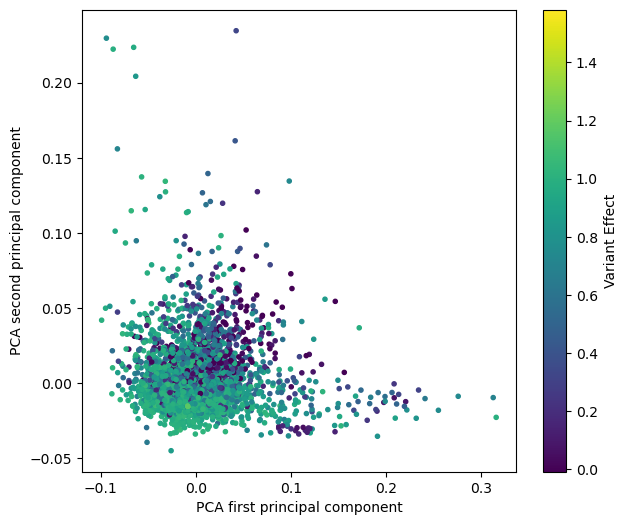

In [47]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=y_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

### Initialize grids for different regression techniques

In [ ]:
knn_grid = [
    {
        'n_neighbors': [5, 10],
        'weights': ['uniform', 'distance'],
        'leaf_size' : [15, 30],
        'p' : [1, 2],
    }
    ]

svm_grid = [
    {
        'C' : [0.1, 1.0, 10.0],
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree' : [3],
        'gamma': ['scale'],
    }
]

In [ ]:
cls_list = [KNeighborsRegressor(), SVR()]
param_grid_list = [knn_grid, svm_grid]

### Run Grid Search

(will take a few minutes on a single core)

In [ ]:
result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    grid = GridSearchCV(
        estimator = cls_name,
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<a id='browse'></a>
## Browse the Sweep Results

The following tables show the top 5 parameter settings, based on `mean_test_score`. Given our setup, this should really be thought of as `validation_score`.

# K Nearest Neighbors

In [ ]:
result_list[0].sort_values('mean_test_score')[:5]

SVM

In [ ]:
result_list[1].sort_values('mean_test_score')[:5]

### Random Forest

In [ ]:
result_list[2].sort_values('mean_test_score')[:5]

<a id='eval'></a>
## Evaluation

Now that we have run grid search, each `grid` object contains a `best_estimator_`.

We can use this to evaluate the correlation between our predictions and the true effect scores on the held-out validation set.

In [ ]:
for grid in grid_list:
    print(grid.best_estimator_.get_params()) # get the model details from the estimator
    print()
    preds = grid.predict(Xs_test)
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print('\n', '-' * 80, '\n')

The SVM performs the best on the `test` set, with a spearman rho of 0.78.